In [1]:
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
import torchvision
from torchvision import transforms as T
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import os
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.metrics import classification_report,  confusion_matrix, ConfusionMatrixDisplay

from augmentation_generator_batch_size import *
from custom_transformers import *

In [2]:
def seed_everything(seed: int=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(51)

## Load data

In [3]:
cifar10 = tf.keras.datasets.cifar10

(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
print(f"X_train.shape: {X_train.shape} \nY_train.shape: {Y_train.shape} \nX_test.shape: {X_test.shape} \nY_test.shape: {Y_test.shape}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step
X_train.shape: (50000, 32, 32, 3) 
Y_train.shape: (50000, 1) 
X_test.shape: (10000, 32, 32, 3) 
Y_test.shape: (10000, 1)


## Random Polygon Cutout - without soft labeling

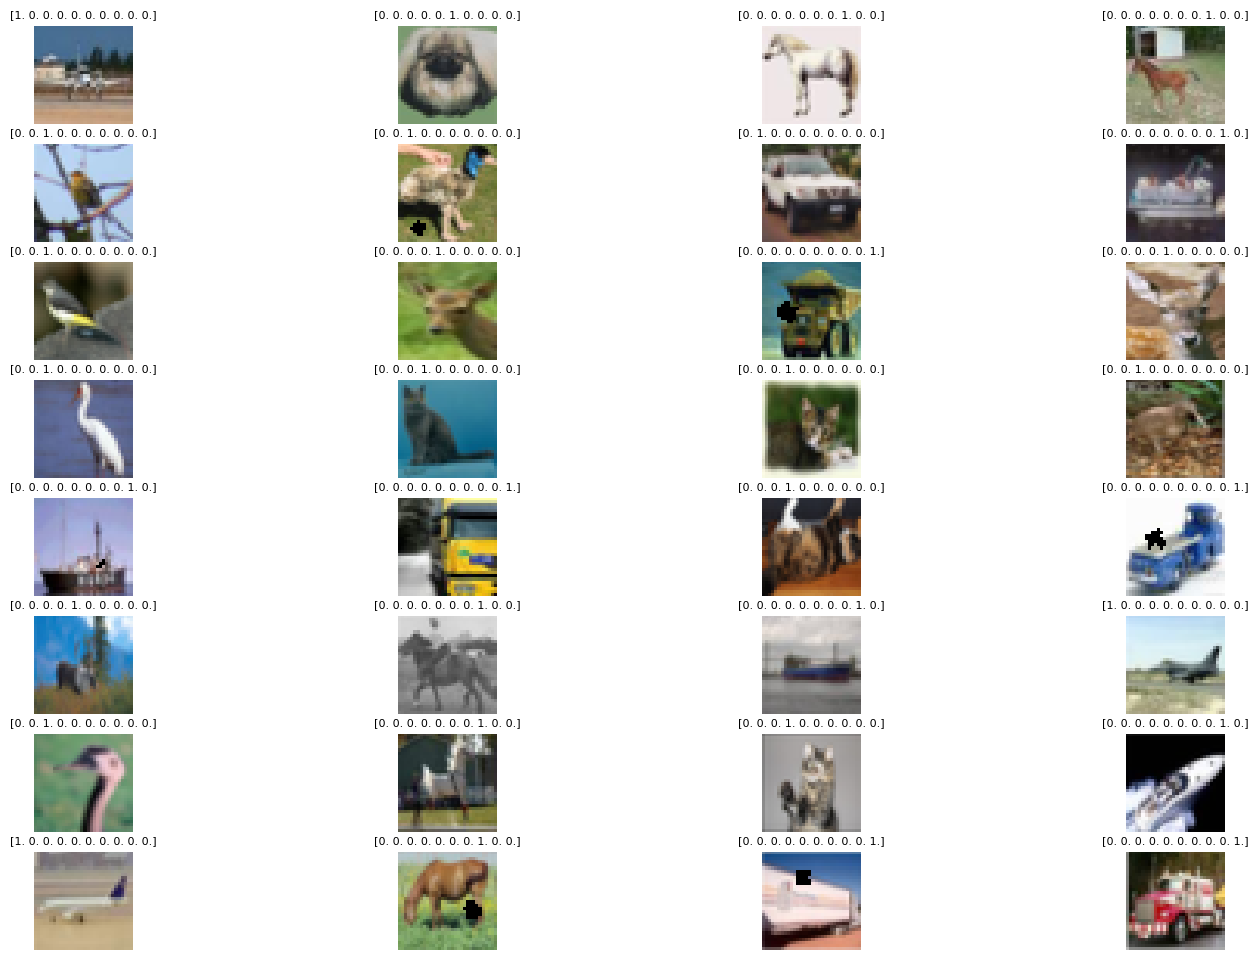

In [ ]:
polygon_cutout = PolygonCutout(max_size_ratio=0.2)
generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32, shuffle=True, augmentor= polygon_cutout, augment_fraction=0.2, overwrite=False, soft_label=False)

batch_x, batch_y = generator[0]

def denormalize(x):
    x = x.copy()
    x = np.clip(x * 255.0, 0, 255)
    return x.astype(np.uint8)

n = len(batch_x)
cols = 4
rows = n//cols + int(n%cols != 0)

fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
if rows == 1 or cols == 1:
    axes = np.expand_dims(axes, axis=0)
for i in range(len(batch_x)):
    row = i // cols
    col = i % cols
    ax = axes[row, col]
    ax.imshow(denormalize(batch_x[i]))
    ax.set_title(batch_y[i], fontsize=8)
    ax.axis('off')

## CNN: max size = 0.2
Without soft labels

In [ ]:
polygon_cutout = PolygonCutout(max_size_ratio=0.2)


train_generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32, shuffle=True, augmentor=polygon_cutout, augment_fraction=0.2, num_classes=10, overwrite=False, soft_label=False)
test_generator = AugmentedCIFAR10Generator(X_test, Y_test, batch_size=32, augmentor=None, shuffle=False)

In [ ]:
k = 10
i = Input(shape=X_train[0].shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.25)(x)

#hidden layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)

#last hidden layer i.e.. output layer
x = Dense(k, activation='softmax')(x)

model = Model(i, x)

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

r = model.fit(
 train_generator, validation_data = test_generator, epochs=6)

Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - accuracy: 0.4519 - loss: 1.7257 - val_accuracy: 0.6297 - val_loss: 1.0339
Epoch 2/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.7012 - loss: 0.8629 - val_accuracy: 0.6878 - val_loss: 0.9193
Epoch 3/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.7657 - loss: 0.6792 - val_accuracy: 0.7529 - val_loss: 0.7311
Epoch 4/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8124 - loss: 0.5511 - val_accuracy: 0.7396 - val_loss: 0.8038
Epoch 5/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8446 - loss: 0.4562 - val_accuracy: 0.7771 - val_loss: 0.6755
Epoch 6/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8721 - loss: 0.3767 - val_accuracy: 0.8028 - val_loss: 0.6190


In [ ]:
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.argmax(test_generator.y_combined, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


              precision    recall  f1-score   support

           0       0.84      0.81      0.82      1000
           1       0.89      0.91      0.90      1000
           2       0.72      0.73      0.72      1000
           3       0.63      0.63      0.63      1000
           4       0.74      0.83      0.78      1000
           5       0.79      0.69      0.73      1000
           6       0.90      0.80      0.85      1000
           7       0.83      0.84      0.84      1000
           8       0.92      0.86      0.89      1000
           9       0.79      0.93      0.86      1000

    accuracy                           0.80     10000
   macro avg       0.81      0.80      0.80     10000
weighted avg       0.81      0.80      0.80     10000



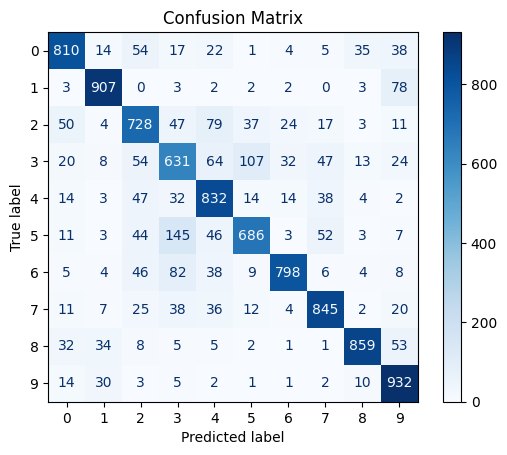

In [ ]:
print(classification_report(y_true, y_pred_classes))
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


Final Training Accuracy: 0.8661
Final Validation Accuracy: 0.8028


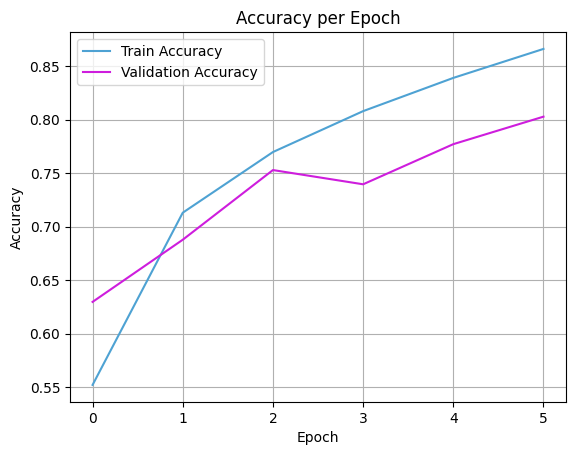

In [ ]:
print(f"Final Training Accuracy: {r.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {r.history['val_accuracy'][-1]:.4f}")
plt.plot(r.history['accuracy'], label='Train Accuracy', color = '#4ea2d3')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy', color = '#ce1ddd')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
epochs = len(r.history['accuracy'])
plt.xticks(ticks=range(epochs))
plt.grid(True)
plt.show()

Final Val Acc : 0.8 </br>
Final Train Acc : 0.87

In [ ]:
model.save('polygon_20.keras')

## CNN : max size = 0.1
Without soft labels



In [ ]:
polygon_cutout = PolygonCutout(max_size_ratio=0.1)


train_generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32, shuffle=True, augmentor=polygon_cutout, augment_fraction=0.2, num_classes=10, overwrite=False, soft_label=False)
test_generator = AugmentedCIFAR10Generator(X_test, Y_test, batch_size=32, augmentor=None, shuffle=False)

In [ ]:
k = 10
i = Input(shape=X_train[0].shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.25)(x)

#hidden layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)

#last hidden layer i.e.. output layer
x = Dense(k, activation='softmax')(x)

model = Model(i, x)

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

r = model.fit(
 train_generator, validation_data = test_generator, epochs=6)

Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - accuracy: 0.4650 - loss: 1.6964 - val_accuracy: 0.6474 - val_loss: 1.0428
Epoch 2/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.7016 - loss: 0.8583 - val_accuracy: 0.7558 - val_loss: 0.7133
Epoch 3/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.7795 - loss: 0.6460 - val_accuracy: 0.7551 - val_loss: 0.7151
Epoch 4/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8124 - loss: 0.5475 - val_accuracy: 0.7777 - val_loss: 0.6639
Epoch 5/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8463 - loss: 0.4437 - val_accuracy: 0.7898 - val_loss: 0.6401
Epoch 6/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8738 - loss: 0.3781 - val_accuracy: 0.7989 - val_loss: 0.6430


## Model statistics

In [ ]:
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.argmax(test_generator.y_combined, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


Classification report

In [ ]:
print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.80      0.83      0.82      1000
           1       0.89      0.91      0.90      1000
           2       0.65      0.78      0.71      1000
           3       0.62      0.66      0.64      1000
           4       0.81      0.72      0.76      1000
           5       0.81      0.59      0.68      1000
           6       0.87      0.83      0.85      1000
           7       0.86      0.84      0.85      1000
           8       0.83      0.93      0.88      1000
           9       0.88      0.89      0.88      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



Confusion matrix

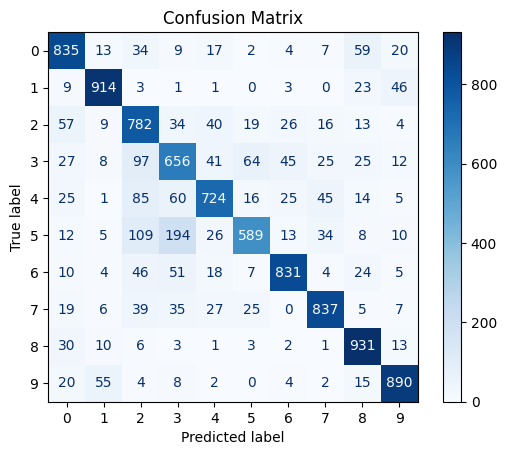

In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

Accuracy

Final Training Accuracy: 0.8687
Final Validation Accuracy: 0.7989


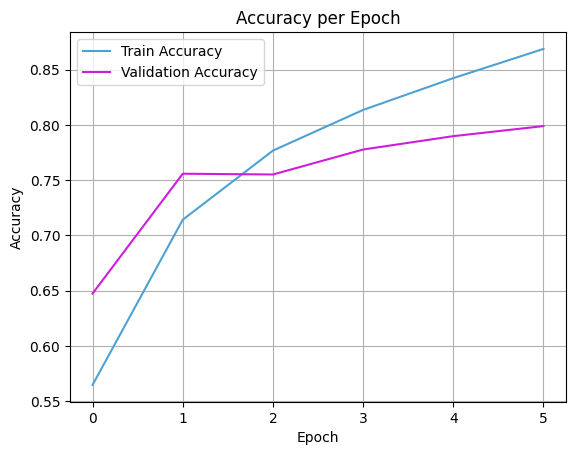

In [ ]:
print(f"Final Training Accuracy: {r.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {r.history['val_accuracy'][-1]:.4f}")
plt.plot(r.history['accuracy'], label='Train Accuracy', color = '#4ea2d3')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy', color = '#ce1ddd')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
epochs = len(r.history['accuracy'])
plt.xticks(ticks=range(epochs))
plt.grid(True)
plt.show()

Final Val Acc : 0.8 </br>
Final Train Acc : 0.87

In [ ]:
model.save('polygon_10.keras')


## CNN : max size 0.05
without soft labels

In [ ]:
random_polygon_5 = PolygonCutout(max_size_ratio=0.05)
train_generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32, shuffle=True, augmentor=random_polygon_5, augment_fraction=0.2, num_classes=10, overwrite=False, soft_label=False)
test_generator = AugmentedCIFAR10Generator(X_test, Y_test, batch_size=32, augmentor=None, shuffle=False)

In [ ]:
k = 10
i = Input(shape=X_train[0].shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.25)(x)

#hidden layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)

#last hidden layer i.e.. output layer
x = Dense(k, activation='softmax')(x)

model = Model(i, x)

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

r = model.fit(
 train_generator, validation_data = test_generator, epochs=6)

Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - accuracy: 0.4666 - loss: 1.7183 - val_accuracy: 0.6687 - val_loss: 0.9362
Epoch 2/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.7012 - loss: 0.8581 - val_accuracy: 0.7288 - val_loss: 0.8041
Epoch 3/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.7686 - loss: 0.6684 - val_accuracy: 0.6956 - val_loss: 0.9968
Epoch 4/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8130 - loss: 0.5490 - val_accuracy: 0.7684 - val_loss: 0.6967
Epoch 5/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8445 - loss: 0.4485 - val_accuracy: 0.7998 - val_loss: 0.6169
Epoch 6/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8730 - loss: 0.3730 - val_accuracy: 0.7833 - val_loss: 0.6644


## Model statistics polygon = 0.05

In [ ]:
y_pred = model.predict(test_generator, steps=len(test_generator), verbose = 1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_generator.y_combined, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


In [ ]:
print(classification_report(y_pred_classes, y_true))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80       980
           1       0.88      0.94      0.91       937
           2       0.76      0.61      0.67      1256
           3       0.65      0.60      0.63      1083
           4       0.86      0.66      0.74      1299
           5       0.56      0.82      0.66       678
           6       0.83      0.85      0.84       978
           7       0.72      0.94      0.81       765
           8       0.88      0.91      0.89       965
           9       0.91      0.86      0.88      1059

    accuracy                           0.78     10000
   macro avg       0.78      0.80      0.78     10000
weighted avg       0.79      0.78      0.78     10000



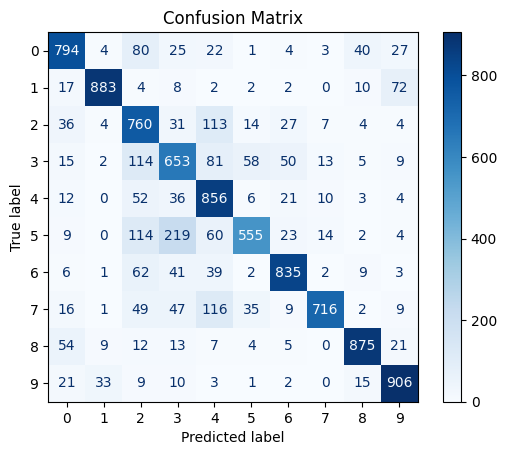

In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Final Training Accuracy: 0.8705
Final Validation Accuracy: 0.7833


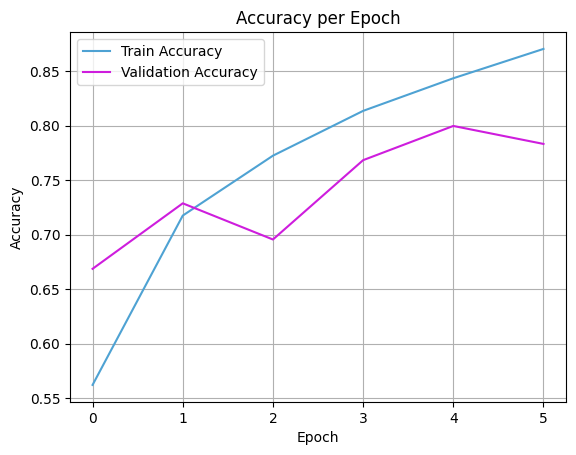

In [ ]:
print(f"Final Training Accuracy: {r.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {r.history['val_accuracy'][-1]:.4f}")
plt.plot(r.history['accuracy'], label='Train Accuracy', color = '#4ea2d3')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy', color = '#ce1ddd')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
epochs = len(r.history['accuracy'])
plt.xticks(ticks=range(epochs))
plt.grid(True)
plt.show()

Final Val Acc : 0.78 </br>
Final Train Acc : 0.87

In [ ]:
model.save('polygon_5.keras')

## CNN : max size 0.05
#with soft labels

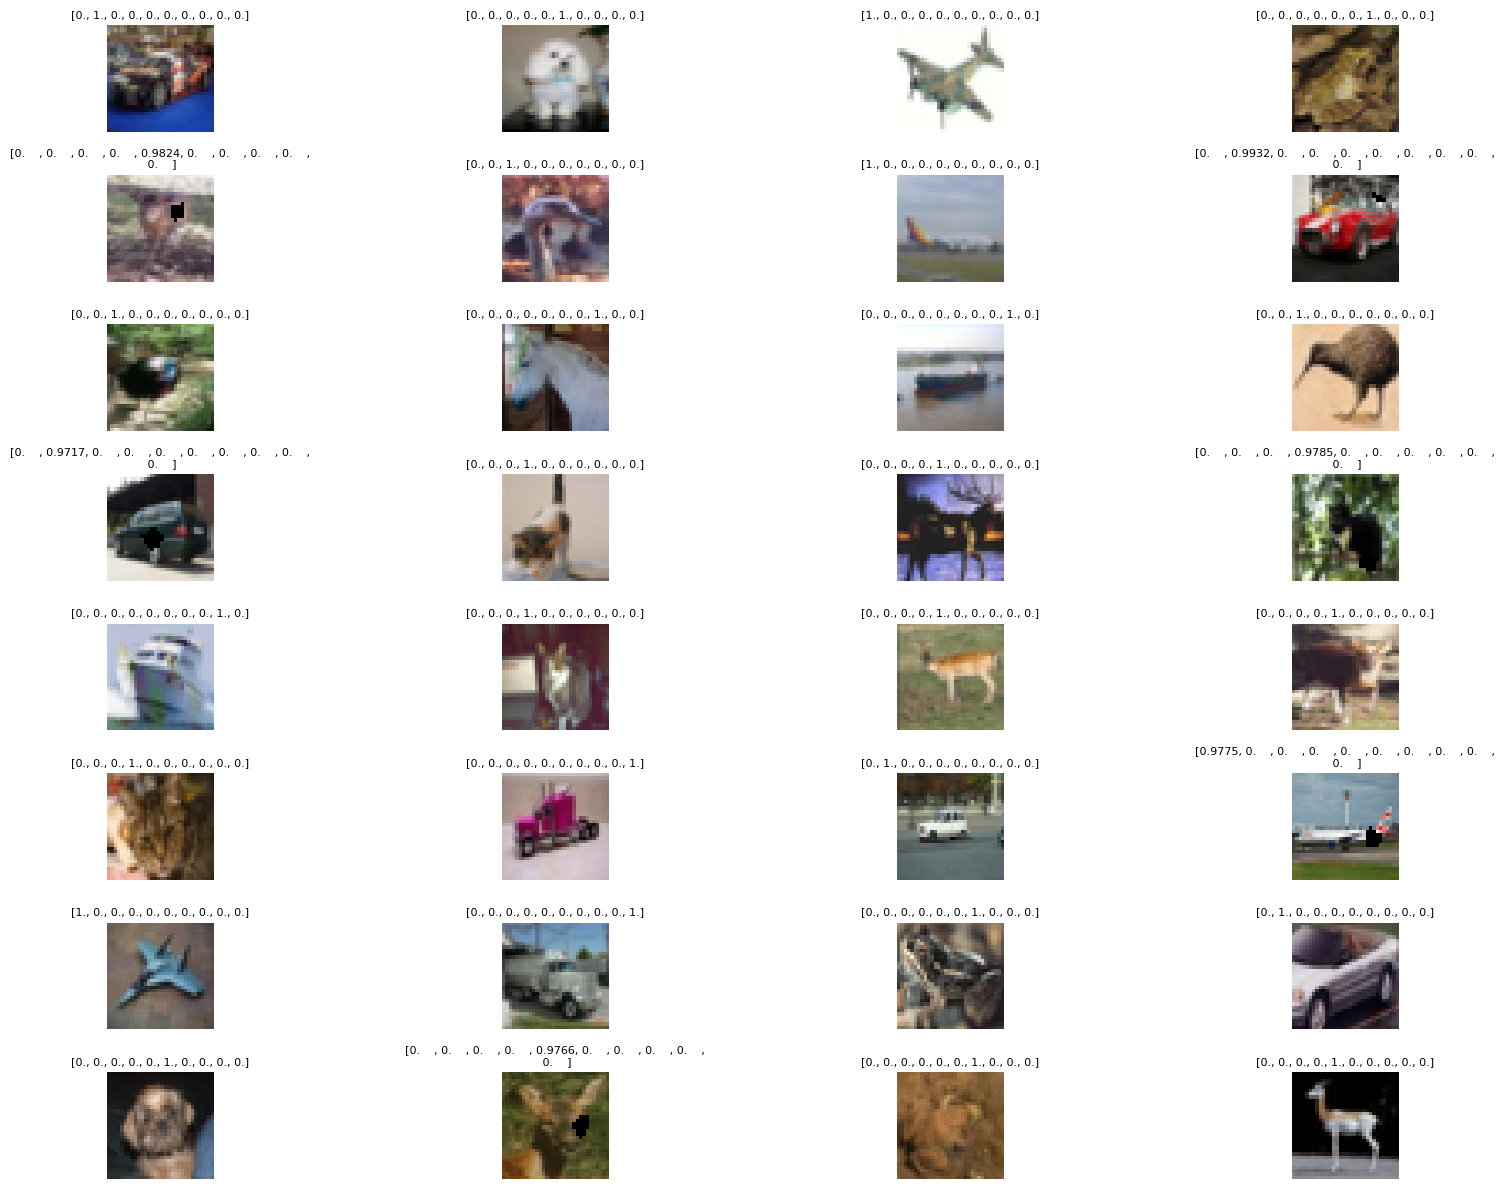

In [ ]:
polygon_5 = PolygonCutout(max_size_ratio=0.2)
generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32, shuffle=True, augmentor= polygon_5, augment_fraction=0.2, overwrite=False, soft_label=True)

batch_x, batch_y = generator[0]

def denormalize(x):
    x = x.copy()
    x = np.clip(x * 255.0, 0, 255)
    return x.astype(np.uint8)

n = len(batch_x)
cols = 4
rows = n//cols + int(n%cols != 0)

fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
if rows == 1 or cols == 1:
    axes = np.expand_dims(axes, axis=0)
for i in range(len(batch_x)):
    row = i // cols
    col = i % cols
    ax = axes[row, col]
    ax.imshow(denormalize(batch_x[i]))

    # Formatowanie soft labeli do 2 miejsc po przecinku
    label_str = np.array2string(batch_y[i], precision=4, separator=', ', suppress_small=True)

    ax.set_title(label_str, fontsize=8)
    ax.axis('off')

plt.tight_layout()


In [ ]:
polygon_5 = PolygonCutout(max_size_ratio=0.05)
train_generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32, shuffle=True, augmentor=polygon_5, augment_fraction=0.2, num_classes=10, overwrite=False, soft_label=True)
test_generator = AugmentedCIFAR10Generator(X_test, Y_test, batch_size=32, augmentor=None, shuffle=False)

In [ ]:
k = 10
i = Input(shape=X_train[0].shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.25)(x)

#hidden layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)

#last hidden layer i.e.. output layer
x = Dense(k, activation='softmax')(x)

model = Model(i, x)

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

r = model.fit(
 train_generator, validation_data = test_generator, epochs=6)

Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - accuracy: 0.4675 - loss: 1.6461 - val_accuracy: 0.5951 - val_loss: 1.3350
Epoch 2/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.7092 - loss: 0.8388 - val_accuracy: 0.7507 - val_loss: 0.7158
Epoch 3/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.7774 - loss: 0.6492 - val_accuracy: 0.7235 - val_loss: 0.8267
Epoch 4/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.8180 - loss: 0.5331 - val_accuracy: 0.7859 - val_loss: 0.6504
Epoch 5/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8484 - loss: 0.4400 - val_accuracy: 0.8108 - val_loss: 0.5871
Epoch 6/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8756 - loss: 0.3619 - val_accuracy: 0.7709 - val_loss: 0.8031


In [ ]:
y_pred = model.predict(test_generator, steps=len(test_generator), verbose = 1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_generator.y_combined, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [ ]:
print(classification_report(y_pred_classes, y_true))

              precision    recall  f1-score   support

           0       0.88      0.71      0.78      1240
           1       0.84      0.91      0.87       919
           2       0.67      0.74      0.71       906
           3       0.48      0.69      0.57       700
           4       0.81      0.76      0.78      1059
           5       0.76      0.62      0.68      1221
           6       0.64      0.96      0.77       665
           7       0.81      0.83      0.82       976
           8       0.93      0.79      0.85      1168
           9       0.90      0.79      0.84      1146

    accuracy                           0.77     10000
   macro avg       0.77      0.78      0.77     10000
weighted avg       0.79      0.77      0.77     10000



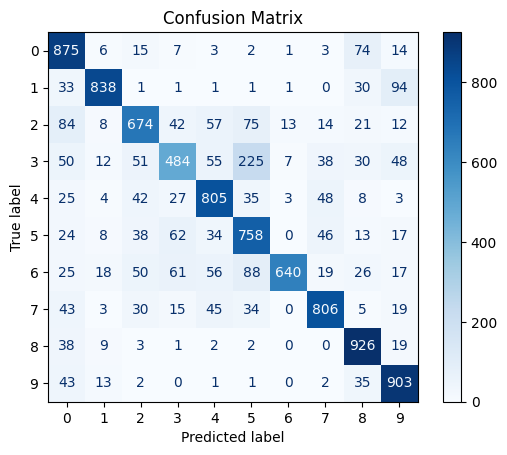

In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Final Training Accuracy: 0.8715
Final Validation Accuracy: 0.7709


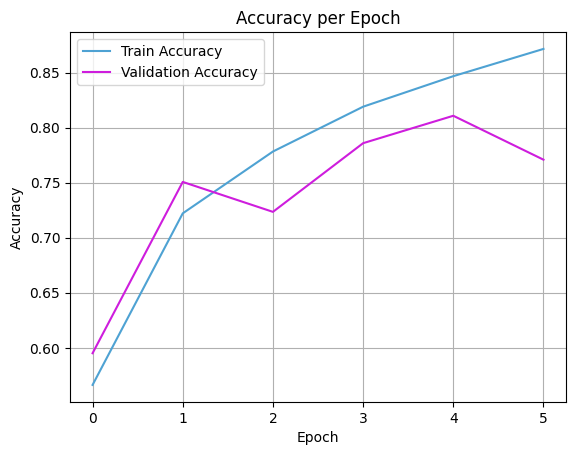

In [ ]:
print(f"Final Training Accuracy: {r.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {r.history['val_accuracy'][-1]:.4f}")
plt.plot(r.history['accuracy'], label='Train Accuracy', color = '#4ea2d3')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy', color = '#ce1ddd')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
epochs = len(r.history['accuracy'])
plt.xticks(ticks=range(epochs))
plt.grid(True)
plt.show()

Final Val Acc : 0.77 </br>
Final Train Acc : 0.87

## CNN : max size 0.05
with soft labels = 0.9999

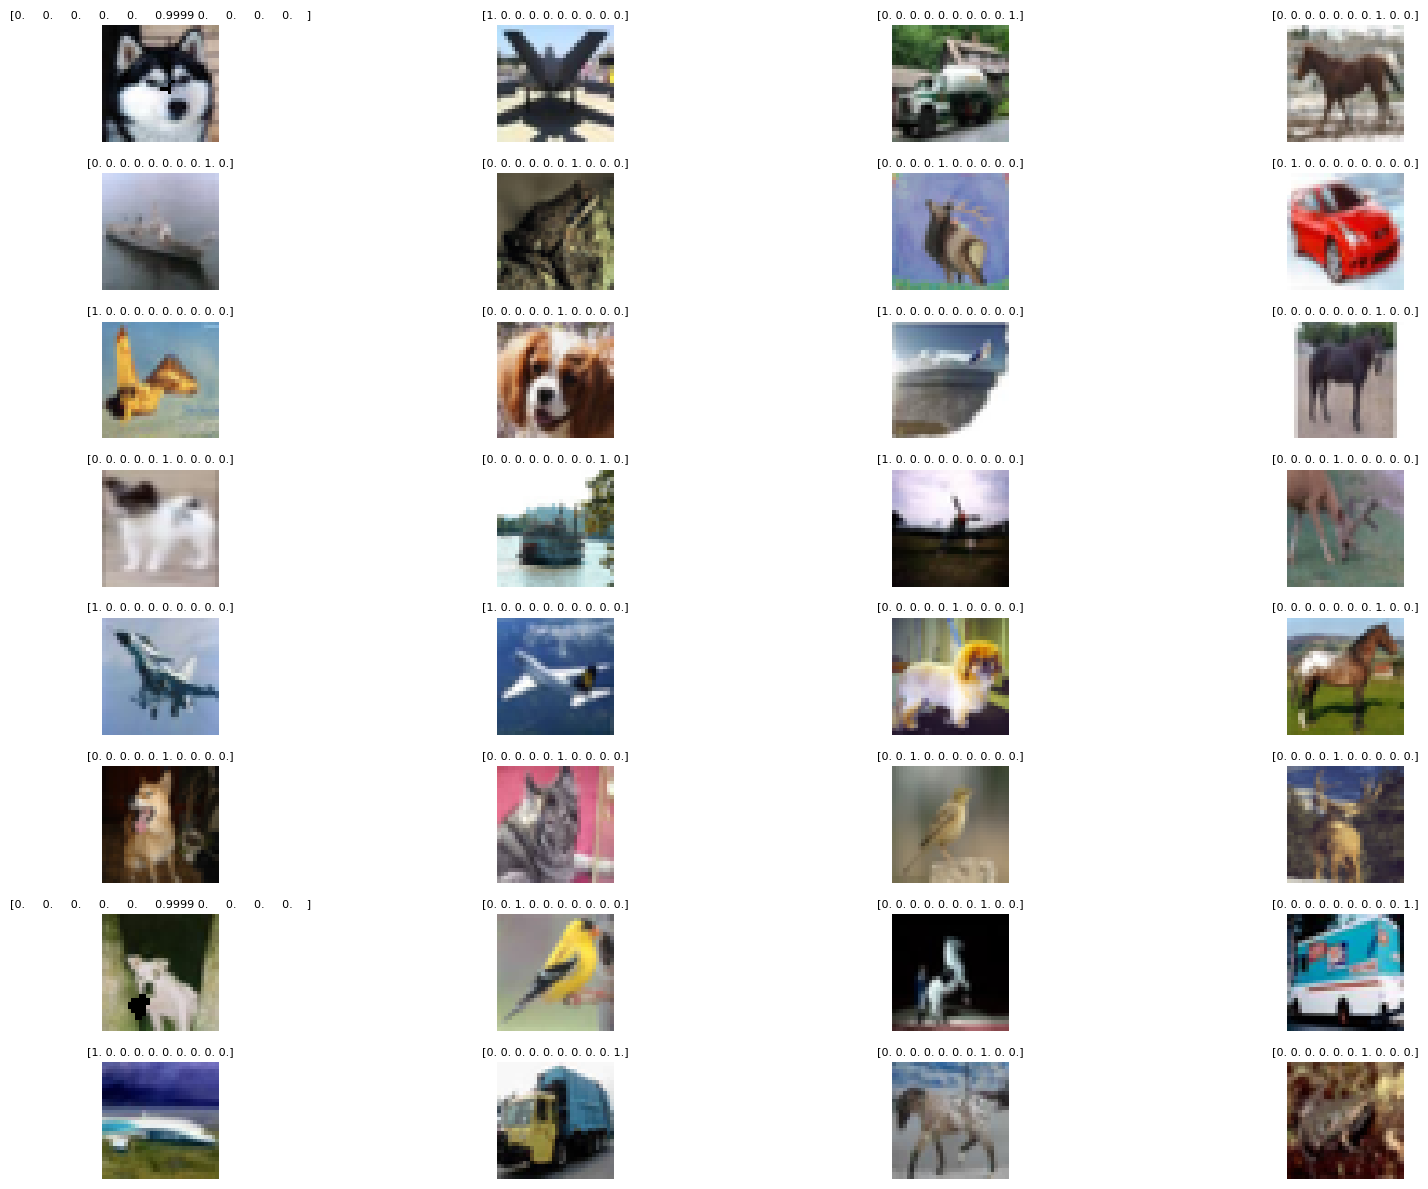

In [ ]:
polygon_5 = PolygonCutout(max_size_ratio=0.2)
generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32, shuffle=True, augmentor= polygon_5, augment_fraction=0.2, overwrite=False, soft_label=True)

batch_x, batch_y = generator[0]

def denormalize(x):
    x = x.copy()
    x = np.clip(x * 255.0, 0, 255)
    return x.astype(np.uint8)

n = len(batch_x)
cols = 4
rows = n//cols + int(n%cols != 0)

fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
if rows == 1 or cols == 1:
    axes = np.expand_dims(axes, axis=0)
for i in range(len(batch_x)):
    row = i // cols
    col = i % cols
    ax = axes[row, col]
    ax.imshow(denormalize(batch_x[i]))

    ax.set_title(batch_y[i], fontsize=8)
    ax.axis('off')

plt.tight_layout()


In [ ]:
polygon_5 = PolygonCutout(max_size_ratio=0.05)
train_generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32, shuffle=True, augmentor=polygon_5, augment_fraction=0.2, num_classes=10, overwrite=False, soft_label=True)
test_generator = AugmentedCIFAR10Generator(X_test, Y_test, batch_size=32, augmentor=None, shuffle=False)

In [ ]:
k = 10
i = Input(shape=X_train[0].shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.25)(x)

#hidden layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)

#last hidden layer i.e.. output layer
x = Dense(k, activation='softmax')(x)

model = Model(i, x)

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

r = model.fit(
 train_generator, validation_data = test_generator, epochs=6)

Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.4749 - loss: 1.6797 - val_accuracy: 0.6683 - val_loss: 0.9508
Epoch 2/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.7056 - loss: 0.8522 - val_accuracy: 0.7085 - val_loss: 0.8380
Epoch 3/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.7716 - loss: 0.6600 - val_accuracy: 0.7622 - val_loss: 0.7122
Epoch 4/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8116 - loss: 0.5473 - val_accuracy: 0.7937 - val_loss: 0.6346
Epoch 5/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8470 - loss: 0.4506 - val_accuracy: 0.7870 - val_loss: 0.6510
Epoch 6/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.8724 - loss: 0.3670 - val_accuracy: 0.8082 - val_loss: 0.6096


In [ ]:
y_pred = model.predict(test_generator, steps=len(test_generator), verbose = 1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_generator.y_combined, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [ ]:
print(classification_report(y_pred_classes, y_true))

              precision    recall  f1-score   support

           0       0.88      0.78      0.83      1131
           1       0.90      0.91      0.90       986
           2       0.70      0.73      0.71       970
           3       0.56      0.71      0.63       797
           4       0.77      0.83      0.80       925
           5       0.68      0.79      0.73       861
           6       0.87      0.83      0.85      1047
           7       0.92      0.73      0.82      1251
           8       0.89      0.89      0.89       995
           9       0.91      0.88      0.89      1037

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.82      0.81      0.81     10000



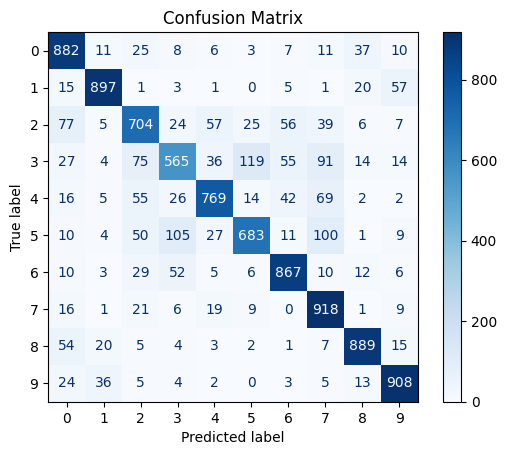

In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Final Training Accuracy: 0.8679
Final Validation Accuracy: 0.8082


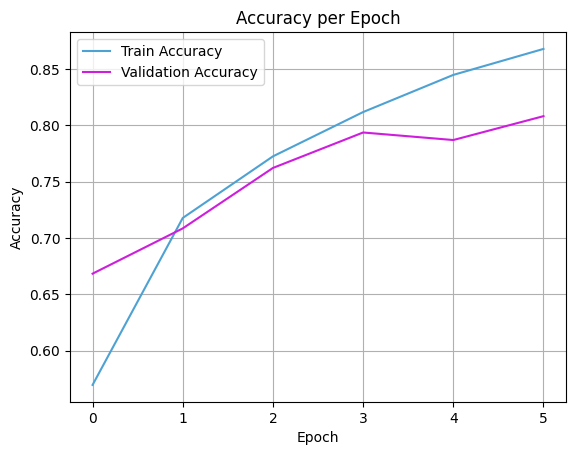

In [ ]:
print(f"Final Training Accuracy: {r.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {er.history['val_accuracy'][-1]:.4f}")
plt.plot(r.history['accuracy'], label='Train Accuracy', color = '#4ea2d3')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy', color = '#ce1ddd')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
epochs = len(r.history['accuracy'])
plt.xticks(ticks=range(epochs))
plt.grid(True)
plt.show()

## CNN : max size 0.05
with soft labels = 0.999

In [4]:
polygon_5 = PolygonCutout(max_size_ratio=0.05)
train_generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32, shuffle=True, augmentor=polygon_5, augment_fraction=0.2, num_classes=10, overwrite=False, soft_label=True, soft_label_fraction=0.999)
test_generator = AugmentedCIFAR10Generator(X_test, Y_test, batch_size=32, augmentor=None, shuffle=False)

In [5]:
k = 10
i = Input(shape=X_train[0].shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.25)(x)

#hidden layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)

#last hidden layer i.e.. output layer
x = Dense(k, activation='softmax')(x)

model = Model(i, x)

In [6]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

r = model.fit(
 train_generator, validation_data = test_generator, epochs=6)

Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.4666 - loss: 1.6681 - val_accuracy: 0.6379 - val_loss: 1.0960
Epoch 2/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.7052 - loss: 0.8462 - val_accuracy: 0.7445 - val_loss: 0.7560
Epoch 3/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.7720 - loss: 0.6620 - val_accuracy: 0.7577 - val_loss: 0.7209
Epoch 4/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8187 - loss: 0.5311 - val_accuracy: 0.7783 - val_loss: 0.6529
Epoch 5/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8484 - loss: 0.4420 - val_accuracy: 0.7895 - val_loss: 0.6570
Epoch 6/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8754 - loss: 0.3637 - val_accuracy: 0.8044 - val_loss: 0.6557


In [7]:
y_pred = model.predict(test_generator, steps=len(test_generator), verbose = 1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_generator.y_combined, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [8]:
print(classification_report(y_pred_classes, y_true))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1006
           1       0.95      0.83      0.88      1150
           2       0.62      0.84      0.71       744
           3       0.80      0.53      0.64      1494
           4       0.79      0.81      0.80       974
           5       0.63      0.80      0.71       796
           6       0.85      0.87      0.86       979
           7       0.81      0.92      0.86       889
           8       0.91      0.88      0.89      1024
           9       0.85      0.90      0.87       944

    accuracy                           0.80     10000
   macro avg       0.80      0.82      0.81     10000
weighted avg       0.81      0.80      0.80     10000



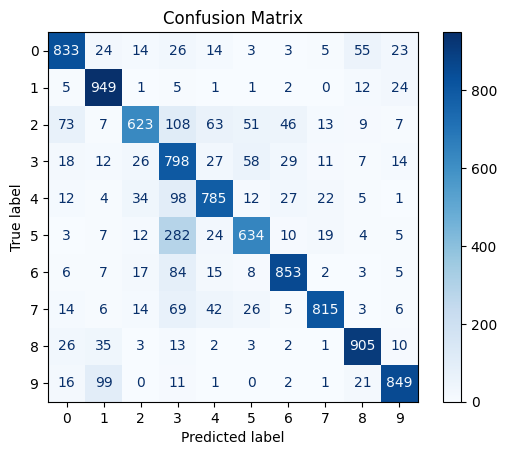

In [9]:
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Final Training Accuracy: 0.8727
Final Validation Accuracy: 0.8044


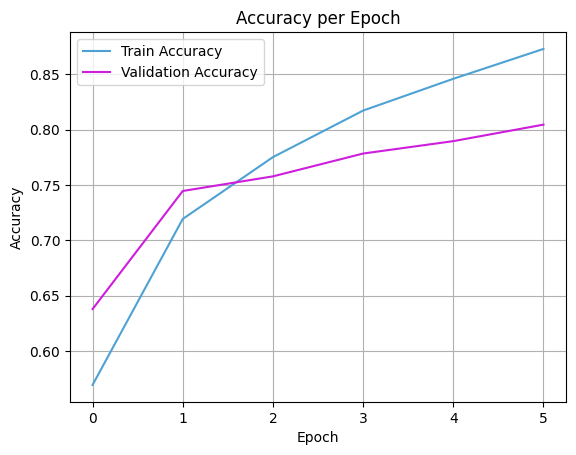

In [11]:
print(f"Final Training Accuracy: {r.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {r.history['val_accuracy'][-1]:.4f}")
plt.plot(r.history['accuracy'], label='Train Accuracy', color = '#4ea2d3')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy', color = '#ce1ddd')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
epochs = len(r.history['accuracy'])
plt.xticks(ticks=range(epochs))
plt.grid(True)
plt.show()

## CNN : max size 0.05
with soft labels = 0.99

In [12]:
polygon_5 = PolygonCutout(max_size_ratio=0.05)
train_generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32, shuffle=True, augmentor=polygon_5, augment_fraction=0.2, num_classes=10, overwrite=False, soft_label=True, soft_label_fraction=0.99)
test_generator = AugmentedCIFAR10Generator(X_test, Y_test, batch_size=32, augmentor=None, shuffle=False)

In [13]:
k = 10
i = Input(shape=X_train[0].shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.25)(x)

#hidden layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)

#last hidden layer i.e.. output layer
x = Dense(k, activation='softmax')(x)

model = Model(i, x)

In [14]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

r = model.fit(
 train_generator, validation_data = test_generator, epochs=6)

Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.4645 - loss: 1.7109 - val_accuracy: 0.6620 - val_loss: 0.9814
Epoch 2/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.7058 - loss: 0.8459 - val_accuracy: 0.7429 - val_loss: 0.7512
Epoch 3/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.7741 - loss: 0.6653 - val_accuracy: 0.5942 - val_loss: 1.3242
Epoch 4/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8133 - loss: 0.5456 - val_accuracy: 0.7609 - val_loss: 0.7235
Epoch 5/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8473 - loss: 0.4413 - val_accuracy: 0.8081 - val_loss: 0.5937
Epoch 6/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8774 - loss: 0.3585 - val_accuracy: 0.8149 - val_loss: 0.5848


In [15]:
y_pred = model.predict(test_generator, steps=len(test_generator), verbose = 1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_generator.y_combined, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [16]:
print(classification_report(y_pred_classes, y_true))

              precision    recall  f1-score   support

           0       0.85      0.82      0.83      1032
           1       0.91      0.91      0.91       997
           2       0.73      0.74      0.74       986
           3       0.69      0.64      0.66      1070
           4       0.80      0.79      0.79      1016
           5       0.65      0.82      0.72       790
           6       0.91      0.79      0.84      1152
           7       0.83      0.88      0.85       941
           8       0.92      0.88      0.90      1042
           9       0.88      0.91      0.89       974

    accuracy                           0.81     10000
   macro avg       0.81      0.82      0.81     10000
weighted avg       0.82      0.81      0.82     10000



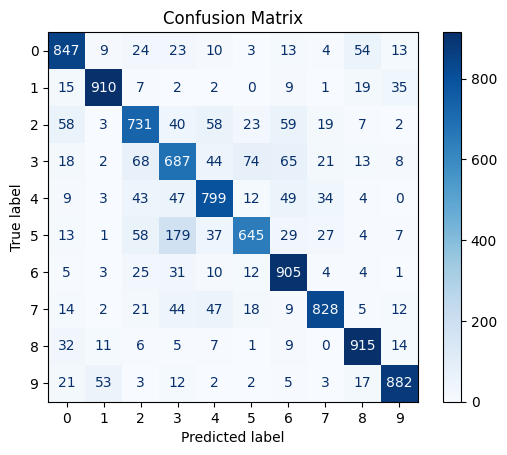

In [17]:
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Final Training Accuracy: 0.8716
Final Validation Accuracy: 0.8149


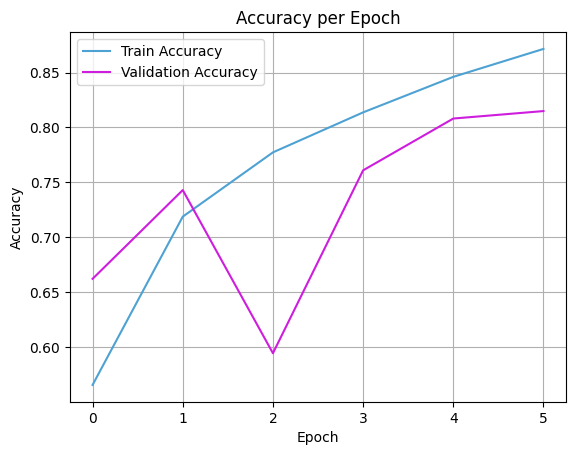

In [18]:
print(f"Final Training Accuracy: {r.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {r.history['val_accuracy'][-1]:.4f}")
plt.plot(r.history['accuracy'], label='Train Accuracy', color = '#4ea2d3')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy', color = '#ce1ddd')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
epochs = len(r.history['accuracy'])
plt.xticks(ticks=range(epochs))
plt.grid(True)
plt.show()